In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
import json
import gzip
import re
import string
import langid
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.optim as optim


# EDA

In [2]:
df = pd.read_csv('english_reviews.csv')

In [3]:
# Filter reviews by length
df['review_length'] = df['cleaned_text'].apply(len)

custom_threshold = df['review_length'].quantile(0.95)

filtered_df = df[df['review_length'] <= custom_threshold]

def remove_numbers(text):
    
    return re.sub(r'\b\d+\w*\b', '', text)

filtered_df['cleaned_text'] = filtered_df['cleaned_text'].apply(remove_numbers)

removed_count = len(df) - len(filtered_df)
print(removed_count)

9638


/var/folders/ry/qcj9vxr15035mpd10wqz_w8m0000gn/T/ipykernel_47900/3152885203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cleaned_text'] = filtered_df['cleaned_text'].apply(remove_numbers)


In [4]:
positive_samples = filtered_df[filtered_df['sentiment'] == 0].sample(n=90000,random_state=26)
negative_samples = filtered_df[filtered_df['sentiment'] == 1].sample(n=90000, random_state=26)

balanced_df = pd.concat([positive_samples, negative_samples])

In [5]:
balanced_df.to_csv('even_reviews.csv', index = False)

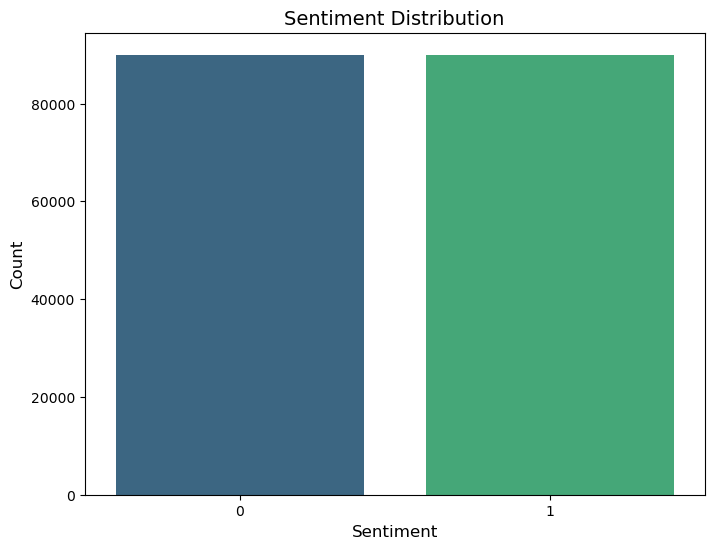

In [6]:
sentiment_counts = balanced_df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sentiment Distribution', fontsize=14)
plt.xticks(fontsize=10)

plt.show()

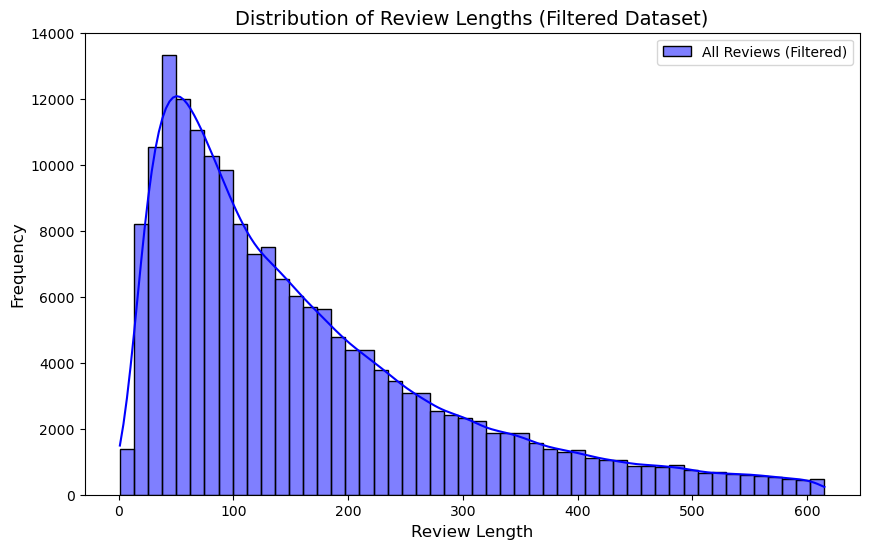

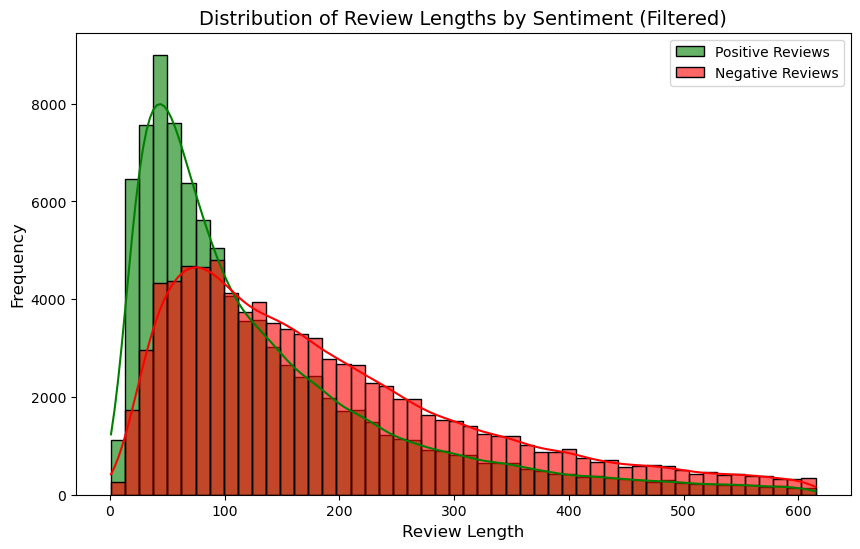

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['review_length'], bins=50, kde=True, color='blue', label='All Reviews (Filtered)')
plt.title('Distribution of Review Lengths (Filtered Dataset)', fontsize=14)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

# Separate filtered data by sentiment
positive_reviews_filtered = filtered_df[filtered_df['sentiment'] == 1]
negative_reviews_filtered = filtered_df[filtered_df['sentiment'] == 0]

# Plot the distribution of review lengths by sentiment (filtered)
plt.figure(figsize=(10, 6))
sns.histplot(positive_reviews_filtered['review_length'], bins=50, kde=True, color='green', label='Positive Reviews', alpha=0.6)
sns.histplot(negative_reviews_filtered['review_length'], bins=50, kde=True, color='red', label='Negative Reviews', alpha=0.6)
plt.title('Distribution of Review Lengths by Sentiment (Filtered)', fontsize=14)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

# Vectorization

In [8]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    ngram_range=(1, 3)
)
tfidf_features = tfidf_vectorizer.fit_transform(balanced_df['cleaned_text'])

# Feature Selection

In [9]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(balanced_df['sentiment'])  

chi2_selector = SelectKBest(chi2, k=300) 
tfidf_features_selected = chi2_selector.fit_transform(tfidf_features, y)

selected_feature_names = [tfidf_vectorizer.get_feature_names_out()[i] for i in chi2_selector.get_support(indices=True)]

print(f"Selected Features (Top {len(selected_feature_names)}):")
print(selected_feature_names)

Selected Features (Top 300):
['advertised', 'amazon', 'apart', 'away', 'awesome', 'bad', 'belt', 'best', 'beware', 'big', 'black', 'bought', 'box', 'br', 'break', 'broke', 'broken', 'buy', 'came', 'cheap', 'cheaper', 'clean', 'close', 'coffee grounds', 'come', 'company', 'compatible', 'completely', 'correct', 'correctly', 'cost', 'couple', 'cracked', 'cup', 'customer service', 'cut', 'cycle', 'damaged', 'days', 'deal', 'defective', 'definitely', 'delivery', 'described', 'description', 'design', 'did', 'did fit', 'did work', 'didnt', 'didnt fit', 'didnt work', 'different', 'difficult', 'disappointed', 'dishwasher', 'does', 'does fit', 'does job', 'does work', 'doesnt', 'doesnt fit', 'doesnt work', 'dont', 'dont buy', 'dont know', 'dont waste', 'dont waste money', 'dryer', 'easier', 'easy', 'easy clean', 'easy install', 'easy use', 'end', 'ended', 'exact', 'exactly', 'exactly needed', 'excellent', 'expected', 'failed', 'far', 'fast', 'filter', 'fit perfect', 'fit perfectly', 'fits', 'fit

# Training and Testing Set

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(tfidf_features_selected, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [11]:
train_counts = pd.Series(y_train).value_counts(normalize=True)
test_counts = pd.Series(y_test).value_counts(normalize=True)

train_percentages = train_counts * 100
test_percentages = test_counts * 100

print(train_percentages,test_percentages)

0    50.148148
1    49.851852
dtype: float64 1    50.141667
0    49.858333
dtype: float64


# Baseline GMM

In [27]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train.toarray())
gmm_labels_test = gmm.predict(X_test.toarray())

In [28]:
accuracy = accuracy_score(y_test, gmm_labels_test)
conf_matrix = confusion_matrix(y_test, gmm_labels_test)
ari = adjusted_rand_score(y_test, gmm_labels_test)

print("Accuracy:", accuracy)
print("ARI:", ari)

Accuracy: 0.7675833333333333
ARI: 0.28638356437127943


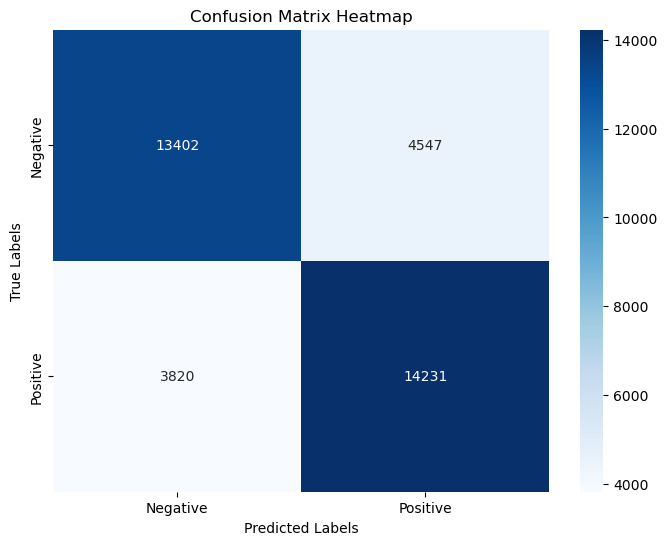

In [29]:
conf_matrix = confusion_matrix(y_test, gmm_labels_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# DGMM

In [15]:
class GMM(nn.Module):
    def __init__(self, input_dim, num_classes, num_gaussians):
        super(GMM, self).__init__()
        self.num_classes = num_classes
        self.num_gaussians = num_gaussians
        self.input_dim = input_dim

        self.mu = nn.Parameter(torch.randn(num_classes, num_gaussians, input_dim))
        self.log_sigma = nn.Parameter(torch.zeros(num_classes, num_gaussians, input_dim))
        self.log_weights = nn.Parameter(torch.zeros(num_classes, num_gaussians))

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1).unsqueeze(2)

        sigma = torch.exp(self.log_sigma)
        diff = x - self.mu.unsqueeze(0)
        log_gaussian = -0.5 * torch.sum((diff / sigma) ** 2 + torch.log(2 * torch.pi * sigma**2), dim=-1)

        log_weights = F.log_softmax(self.log_weights, dim=-1)
        log_prob = log_gaussian + log_weights.unsqueeze(0)

        log_prob = torch.logsumexp(log_prob, dim=-1)

        return -log_prob

class DGMM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_gaussians):
        super(DGMM, self).__init__()

        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        self.bottleneck = nn.Linear(2 * hidden_dim, input_dim) 

        self.gmm_layer = GMM(input_dim, num_classes, num_gaussians)

    def forward(self, x):
        x = x.unsqueeze(1)  

        rnn_out, _ = self.rnn(x)

        rnn_out = rnn_out[:, -1, :] 

        bottleneck_features = self.bottleneck(rnn_out)

        log_likelihood = self.gmm_layer(bottleneck_features)

        return log_likelihood


In [16]:
def create_dataloader(X, y, batch_size=5):
    y = np.array(y)
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_model_with_validation(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')  
    best_model_state = None     

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            log_likelihood = model(batch_data)
            loss = criterion(log_likelihood, batch_labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            predictions = torch.argmax(log_likelihood, dim=1)
            correct_train += (predictions == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        train_losses.append(total_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        val_losses.append(total_val_loss)
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch + 1}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_model_state = model.state_dict()


    torch.save(best_model_state, "best_model.pth")
    print("Best model saved with Validation Loss: {:.4f}".format(best_val_loss))


    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses,  label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses,  label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies,  label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def test_model(model, criterion, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))

    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            total_test_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            correct_test += (predictions == batch_labels).sum().item()
            total_test += batch_labels.size(0)

    test_accuracy = correct_test / total_test

    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


Epoch 1, Train Loss: 5158.5215, Val Loss: 1563.2339, Train Accuracy: 0.5185, Val Accuracy: 0.5033
Epoch 2, Train Loss: 4617.6544, Val Loss: 1530.0148, Train Accuracy: 0.6050, Val Accuracy: 0.7322
Epoch 3, Train Loss: 4462.8412, Val Loss: 1440.2003, Train Accuracy: 0.7133, Val Accuracy: 0.7333
Epoch 4, Train Loss: 4123.6355, Val Loss: 1293.0985, Train Accuracy: 0.7650, Val Accuracy: 0.7581
Epoch 5, Train Loss: 3590.8830, Val Loss: 1102.5206, Train Accuracy: 0.7932, Val Accuracy: 0.8097
Epoch 6, Train Loss: 3114.7111, Val Loss: 977.7196, Train Accuracy: 0.8183, Val Accuracy: 0.8363
Epoch 7, Train Loss: 2855.3856, Val Loss: 921.6015, Train Accuracy: 0.8350, Val Accuracy: 0.8435
Epoch 8, Train Loss: 2756.5868, Val Loss: 897.7245, Train Accuracy: 0.8403, Val Accuracy: 0.8574
Epoch 9, Train Loss: 2729.7553, Val Loss: 896.0902, Train Accuracy: 0.8457, Val Accuracy: 0.8593
Epoch 10, Train Loss: 2719.9779, Val Loss: 909.6968, Train Accuracy: 0.8490, Val Accuracy: 0.8224
Epoch 11, Train Loss: 27

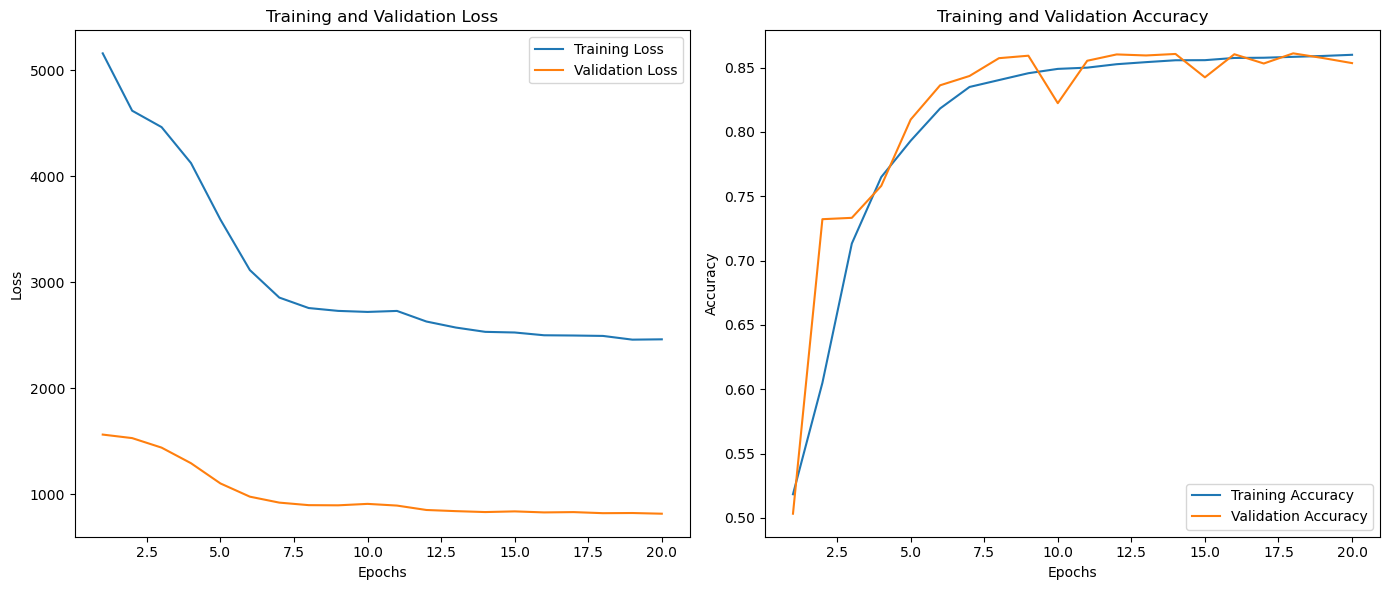

In [17]:
device = torch.device("mps")
input_dim = X_train.shape[1]
hidden_dims = 64
num_classes = 2  
num_gaussians = 10

model = DGMM(input_dim, hidden_dims, num_classes, num_gaussians).to(device)
train_loader = create_dataloader(X_train, y_train, batch_size=16)
val_loader = create_dataloader(X_val, y_val, batch_size=16)
test_loader = create_dataloader(X_test, y_test, batch_size=16)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


train_model_with_validation(model, criterion, optimizer, train_loader, val_loader)

In [19]:
test_accuracy = test_model(model, criterion, test_loader)



Test Accuracy: 0.8518


# Simple NN

In [20]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        
        # LSTM layer for sequential feature extraction
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        
        # Bottleneck layer (reduces dimensionality)
        self.bottleneck = nn.Linear(2 * hidden_dim, input_dim)
        
        # Fully connected classification layer
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Add sequence dimension if missing
        x = x.unsqueeze(1)
        
        # LSTM layer
        rnn_out, _ = self.rnn(x)
        
        # Get the last hidden state
        rnn_out = rnn_out[:, -1, :] 
        
        # Bottleneck layer
        bottleneck_features = self.bottleneck(rnn_out)
        
        # Fully connected classification
        logits = self.fc(bottleneck_features)
        
        return logits


In [21]:
def create_dataloader(X, y, batch_size=5):
    y = np.array(y)
    if hasattr(X, "toarray"):
        X = X.toarray()
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_model_with_validation(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')  
    best_model_state = None     

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            log_likelihood = model(batch_data)
            loss = criterion(log_likelihood, batch_labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            predictions = torch.argmax(log_likelihood, dim=1)
            correct_train += (predictions == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        train_losses.append(total_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs, dim=1)
                correct_val += (predictions == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        val_losses.append(total_val_loss)
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch + 1}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            best_model_state = model.state_dict()


    torch.save(best_model_state, "best_model.pth")
    print("Best model saved with Validation Loss: {:.4f}".format(best_val_loss))


    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses,  label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses,  label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies,  label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def test_model(model, criterion, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))

    model.eval()
    total_test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            total_test_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            correct_test += (predictions == batch_labels).sum().item()
            total_test += batch_labels.size(0)

    test_accuracy = correct_test / total_test

    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


Epoch 1, Train Loss: 4678.8842, Val Loss: 1559.2171, Train Accuracy: 0.5019, Val Accuracy: 0.4987
Epoch 2, Train Loss: 4676.1725, Val Loss: 1558.3560, Train Accuracy: 0.5515, Val Accuracy: 0.5021
Epoch 3, Train Loss: 4665.6847, Val Loss: 1550.4934, Train Accuracy: 0.6188, Val Accuracy: 0.7215
Epoch 4, Train Loss: 4606.8534, Val Loss: 1506.3247, Train Accuracy: 0.7277, Val Accuracy: 0.7363
Epoch 5, Train Loss: 4247.8032, Val Loss: 1276.4490, Train Accuracy: 0.7705, Val Accuracy: 0.8208
Epoch 6, Train Loss: 3401.3806, Val Loss: 1022.9223, Train Accuracy: 0.8017, Val Accuracy: 0.8523
Epoch 7, Train Loss: 2959.1571, Val Loss: 958.4148, Train Accuracy: 0.8190, Val Accuracy: 0.8017
Epoch 8, Train Loss: 2870.3732, Val Loss: 944.5987, Train Accuracy: 0.8267, Val Accuracy: 0.8570
Epoch 9, Train Loss: 2834.7202, Val Loss: 934.0873, Train Accuracy: 0.8358, Val Accuracy: 0.8435
Epoch 10, Train Loss: 2824.7167, Val Loss: 934.2916, Train Accuracy: 0.8406, Val Accuracy: 0.8455
Epoch 11, Train Loss: 2

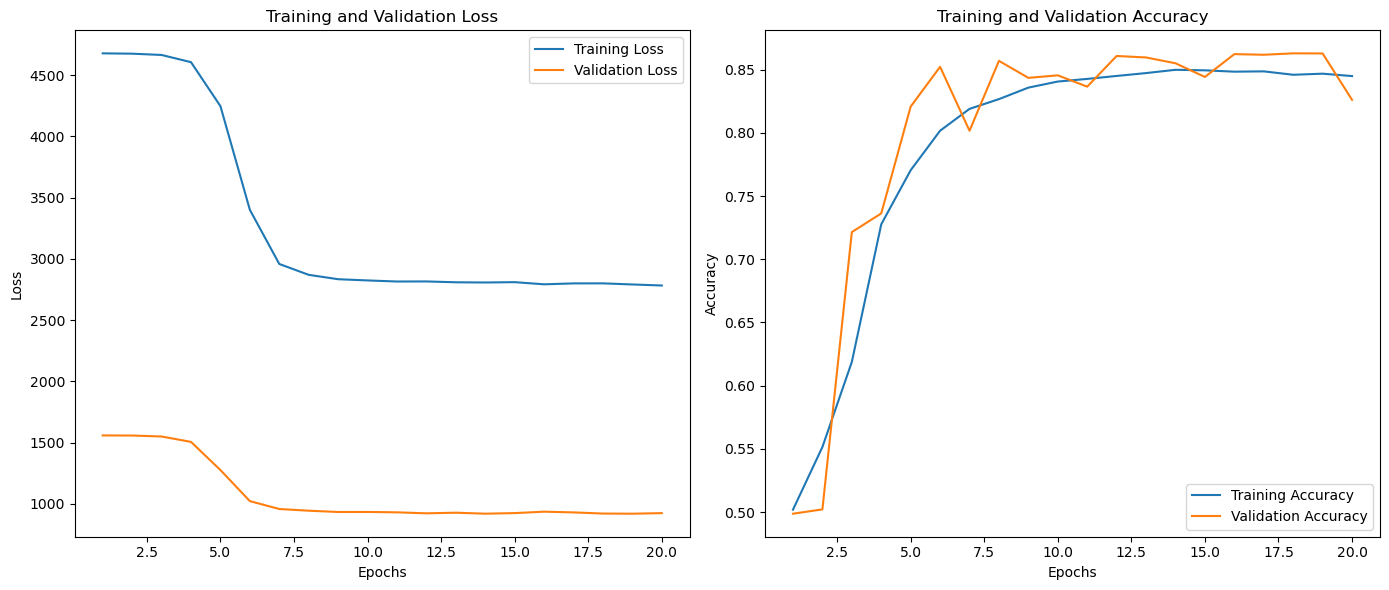

In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

input_dim = X_train.shape[1]  
hidden_dims = 64  
num_classes = 2  

model = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dims, num_classes=num_classes).to(device)


train_loader = create_dataloader(X_train, y_train, batch_size=16)
val_loader = create_dataloader(X_val, y_val, batch_size=16)
test_loader = create_dataloader(X_test, y_test, batch_size=16)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

train_model_with_validation(model, criterion, optimizer, train_loader, val_loader)



In [23]:
test_model(model, criterion, test_loader)

Test Accuracy: 0.8252


0.8251944444444445